# Circle detection - v1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
import scipy.ndimage as ndi

Loading the image and verifying it's with 3 channels

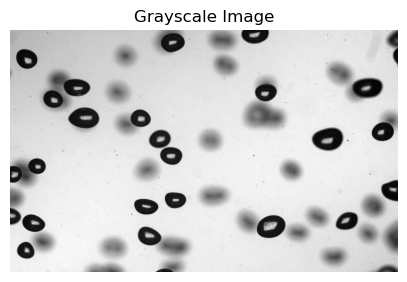

In [3]:
# Load the image
image = io.imread("/Users/noedaniel/Desktop/Image Processing/frame_000030.tif")

if image.ndim == 3:
    image_gray = color.rgb2gray(image)
else:
    image_gray = image

plt.figure(figsize=(5, 5))
plt.imshow(image_gray, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')
plt.show()

### Tresholding phase

Treshold (the values need to be tested before on ImageJ to remove under surface bubbles). We do a over/under treshold (like on ImageJ)

/var/folders/_5/450_dsxx7pqfnwb2rs5wpndm0000gn/T/ipykernel_52890/2546955169.py:7: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  over_under_threshold_image[image_gray < lower_threshold] = -1


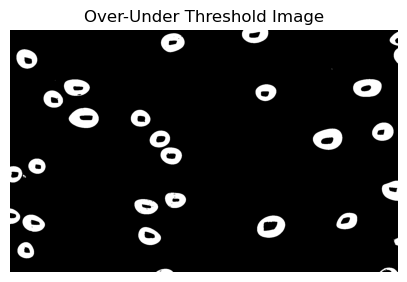

In [5]:
# Define the lower and upper threshold values
lower_threshold = 60
upper_threshold = 255

over_under_threshold_image = np.zeros_like(image_gray)
over_under_threshold_image[image_gray > upper_threshold] = 1
over_under_threshold_image[image_gray < lower_threshold] = -1

plt.figure(figsize=(5, 5))
plt.imshow(over_under_threshold_image, cmap='gray')
plt.title("Over-Under Threshold Image")
plt.axis('off')
plt.show()

### Canny filtering.

Once the tresholding is done, we apply Canny filter

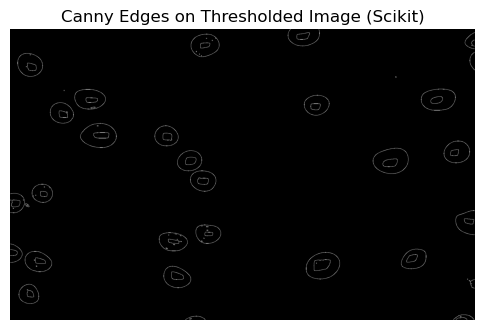

In [6]:
from skimage.feature import canny

# Perform Canny edge detection
edges_canny_skimage = canny(over_under_threshold_image.astype(float), sigma=1.0)

plt.figure(figsize=(6, 6))
plt.imshow(edges_canny_skimage, cmap='gray')
plt.title("Canny Edges on Thresholded Image (Scikit)")
plt.axis("off")
plt.show()

Highlighting edges, we get

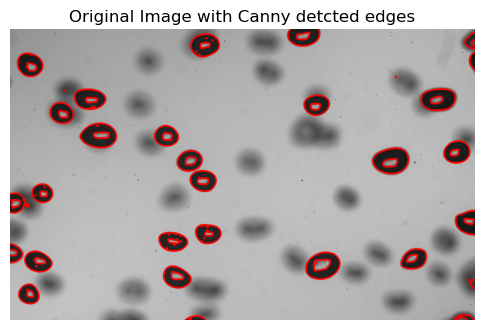

In [8]:
# Create a copy of the original image to draw on and convert to RGB
overlay_image = np.stack([image] * 3, axis=-1)

# Increase the thickness of the edges
thick_edges = ndi.binary_dilation(edges_canny_skimage, iterations=3)

# Set the red color for the edges
overlay_image[thick_edges] = [255, 0, 0]

plt.figure(figsize=(6, 6))
plt.imshow(overlay_image)
plt.title("Original Image with Canny detcted edges")
plt.axis("off")
plt.show()

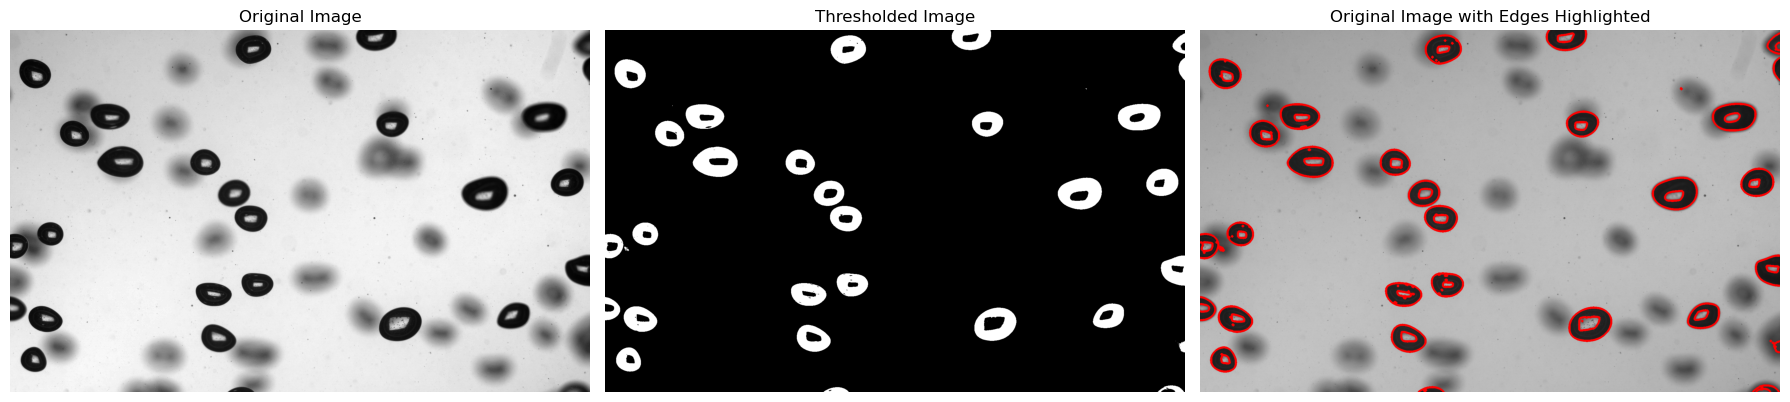

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(image, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(over_under_threshold_image, cmap='gray')
axes[1].set_title("Thresholded Image")
axes[1].axis('off')

axes[2].imshow(overlay_image)
axes[2].set_title("Original Image with Edges Highlighted")
axes[2].axis('off')

plt.tight_layout()
plt.show()

### Filling the bubbles

Let's use `binary_fill_holes`to improve the process

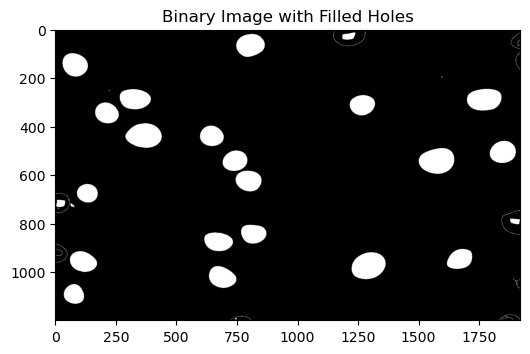

In [11]:
filled_image = ndi.binary_fill_holes(edges_canny_skimage)

# Visualize the filled binary image
plt.figure(figsize=(6, 6))
plt.imshow(filled_image, cmap='gray')
plt.title("Binary Image with Filled Holes")
plt.axis()
plt.show()

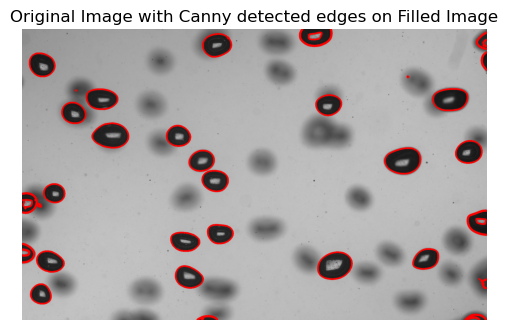

In [12]:
# Perform Canny edge detection on the filled image
edges_canny_filled = canny(filled_image.astype(float), sigma=1.0)

# Increase the thickness of the edges
thick_edges_filled = ndi.binary_dilation(edges_canny_filled, iterations=3)

# Create a copy of the original image to draw on and convert to RGB
overlay_image_filled = np.stack([image] * 3, axis=-1)

# Set the red color for the edges
overlay_image_filled[thick_edges_filled] = [255, 0, 0]

plt.figure(figsize=(6, 6))
plt.imshow(overlay_image_filled)
plt.title("Original Image with Canny detected edges on Filled Image")
plt.axis("off")
plt.show()

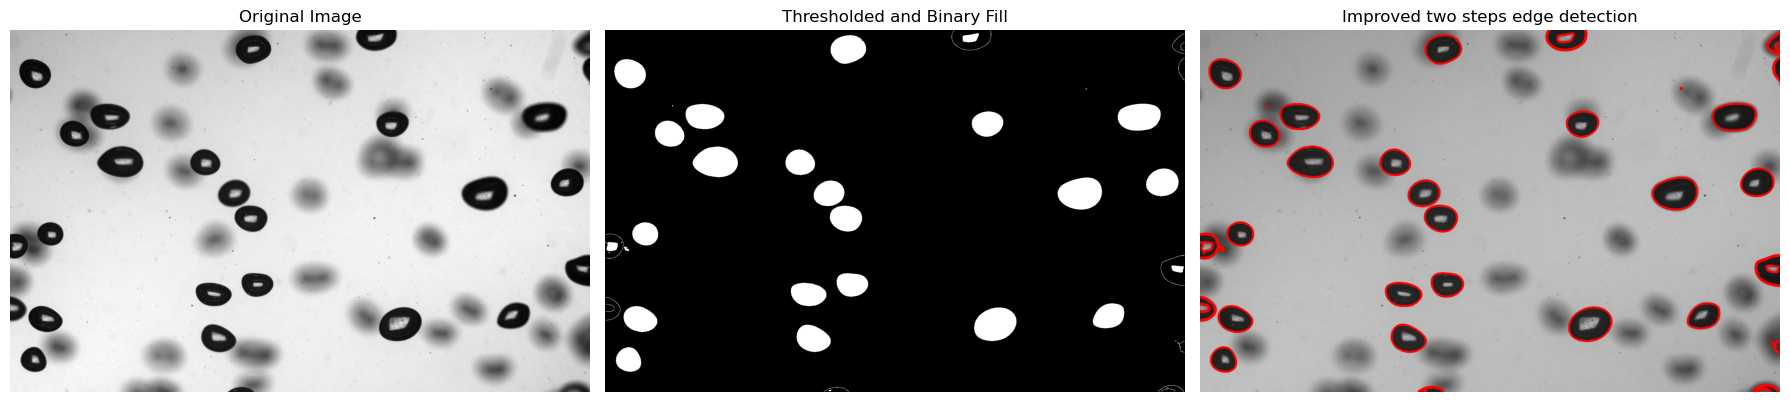

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(image, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(filled_image, cmap='gray')
axes[1].set_title("Thresholded and Binary Fill")
axes[1].axis('off')

axes[2].imshow(overlay_image_filled)
axes[2].set_title("Improved two steps edge detection")
axes[2].axis('off')

plt.tight_layout()
plt.show()

### Hough transform